In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score
from scipy.sparse import hstack
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.simplefilter("ignore")

In [2]:
dates_train = ['ticket_issued_date', 'hearing_date', 'payment_date']
dates_test = ['ticket_issued_date', 'hearing_date']
train = pd.read_csv("../Тестовые задания/train_2.csv", index_col = 0, parse_dates = [i for i in dates_train])
test =  pd.read_csv("../Тестовые задания/test_2.csv", index_col = 0, parse_dates = [i for i in dates_test])

In [3]:
train.dtypes.value_counts()

object            16
float64           14
datetime64[ns]     3
int64              1
dtype: int64

In [4]:
train.shape, test.shape

((225000, 34), (25305, 27))

In [5]:
train.head(3)

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,0.0,305.0,0.0,305.0,NaT,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,0.0,855.0,780.0,75.0,2005-06-02,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,...,0.0,0.0,0.0,0.0,NaT,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN


In [6]:
test.head(3)

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,grafitti_status
225001,259669,"Buildings, Safety Engineering & Env Department","Sloane, Bennie J","Jobczyk, Richard",5502.0,CHOPIN,NaN,556.0,Chopin,Detroit,...,Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,NaN
225002,259733,"Buildings, Safety Engineering & Env Department","Sloane, Bennie J","Jobczyk, Richard",5502.0,CHOPIN,NaN,556.0,Chopin,Detroit,...,Failure to obtain certificate of registration ...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,NaN
225003,258776,"Buildings, Safety Engineering & Env Department","Addison, Michael","REAL ESTATE, S & N",7661.0,VERNOR,NaN,319.0,WATERFALL,TROY,...,Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,NaN


### EDA

In [7]:
print(train.shape, test.shape)
rows = train.shape[0] + test.shape[0]
print(train.shape[0] / rows, test.shape[0] / rows)
print()

(225000, 34) (25305, 27)
0.8989033379277281 0.10109666207227183



In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225000 entries, 0 to 224999
Data columns (total 34 columns):
ticket_id                     225000 non-null int64
agency_name                   225000 non-null object
inspector_name                225000 non-null object
violator_name                 224969 non-null object
violation_street_number       225000 non-null float64
violation_street_name         225000 non-null object
violation_zip_code            0 non-null float64
mailing_address_str_number    222105 non-null float64
mailing_address_str_name      224996 non-null object
city                          225000 non-null object
state                         224979 non-null object
zip_code                      224999 non-null object
non_us_str_code               1 non-null object
country                       225000 non-null object
ticket_issued_date            225000 non-null datetime64[ns]
hearing_date                  214104 non-null datetime64[ns]
violation_code                225

In [9]:
train.describe()

,ticket_id,violation_street_number,violation_zip_code,mailing_address_str_number,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,grafitti_status,compliance
count,225000.000000,2.250000e+05,0.0,2.221050e+05,224999.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.0,225000.000000,225000.000000,225000.000000,0.0,144528.000000
mean,139236.542458,1.064427e+04,NaN,9.247658e+03,378.468793,12.846933,6.423467,21.923544,0.137867,0.0,274.147722,50.951902,225.868484,NaN,0.072560
std,69554.395583,3.353385e+04,NaN,3.679203e+04,729.659232,9.586208,4.793104,58.716439,3.614186,0.0,651.622194,230.959662,629.964750,NaN,0.259414
min,18645.000000,0.000000e+00,NaN,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-7750.000000,NaN,0.000000
25%,79805.750000,4.762000e+03,NaN,5.520000e+02,200.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,NaN,0.000000
50%,139140.500000,1.030000e+04,NaN,2.484000e+03,250.000000,20.000000,10.000000,10.000000,0.000000,0.0,140.000000,0.000000,25.000000,NaN,0.000000
75%,199471.750000,1.572925e+04,NaN,1.312700e+04,250.000000,20.000000,10.000000,25.000000,0.000000,0.0,305.000000,0.000000,305.000000,NaN,0.000000
max,261048.000000,1.415411e+07,NaN,5.111345e+06,10000.000000,20.000000,10.000000,1000.000000,350.000000,0.0,11030.000000,11075.000000,11030.000000,NaN,1.000000


#### Explore the main features

In [10]:
# Изучим всех налогоплательщиков по-отдельности: оплатившие и неоплатившие, соответственно
train_paid = train[train['compliance'] == 1]
train_not_paid = train[train['compliance'] == 0]
train_paid.shape, train_not_paid.shape

((10487, 34), (134041, 34))

In [11]:
# Интересно посмотреть, кто из инспекторов и агенств чаще всего штрафовал налогплательщиков
train.groupby(['compliance'])['agency_name'].value_counts()

compliance  agency_name                                   
0.0         Buildings, Safety Engineering & Env Department    83435
            Department of Public Works                        40621
            Health Department                                  6639
            Detroit Police Department                          3345
            Neighborhood City Halls                               1
1.0         Buildings, Safety Engineering & Env Department     5563
            Department of Public Works                         3979
            Detroit Police Department                           477
            Health Department                                   468
Name: agency_name, dtype: int64

Как видно, чаще всего налоги не оплачивают в сферах Строительства, Инженерии и Экологии

In [12]:
train.groupby(['compliance'])['inspector_name'].value_counts().head()

compliance  inspector_name  
0.0         Morris, John        10043
            O'Neal, Claude       7530
            Samaan, Neil J       7262
            Devaney, John        6441
            Steele, Jonathan     6090
Name: inspector_name, dtype: int64

Morris John охотник на налогонеплательщиков)

In [13]:
# Взглянем ещё и на тех, кто чаще всего не платит налоги
train.groupby(['compliance'])['violator_name'].value_counts().head()

compliance  violator_name        
0.0         INVESTMENT, ACORN        618
            INVESTMENT CO., ACORN    343
            BANK, WELLS FARGO        241
            MILLER, JOHN             168
            NEW YORK, BANK OF        135
Name: violator_name, dtype: int64

In [14]:
train_paid['violation_description'].value_counts().head()

Failure of owner to obtain certificate of compliance                                                    4562
Failure of owner to keep property, its sidewalks, or adjoining public property free from solid waste    1352
Excessive weeds or plant growth one- or two-family dwelling or commercial Building                      1111
Failure to obtain certificate of registration for rental property                                        718
Violation of time limit for approved containers to remain at curbside - early or late                    536
Name: violation_description, dtype: int64

In [15]:
train_not_paid['violation_description'].value_counts().head()

Failure of owner to obtain certificate of compliance                                                    55898
Failure to obtain certificate of registration for rental property                                       21190
Failure of owner to keep property, its sidewalks, or adjoining public property free from solid waste    17720
Excessive weeds or plant growth one- or two-family dwelling or commercial Building                      12630
Violation of time limit for approved containers to remain at curbside - early or late                    3538
Name: violation_description, dtype: int64

Самые популярные описания нарушений среди налогонеплательщиков:
1. Неспособность владельца получить сертификат соответствия
2. Непредставление свидетельства о регистрации арендуемого имущества
3. Неспособность владельца содержать имущество, его тротуары или прилегающую общественную собственность без твердых отходов
4. Чрезмерные сорняки или рост растений жилое или коммерческое здание на одну или две семьи
5. Нарушение срока пребывания утвержденных контейнеров на обочине-рано или поздно

In [16]:
train_paid['discount_amount'].value_counts().head()

0.0     9383
25.0     587
5.0      154
10.0     139
20.0     110
Name: discount_amount, dtype: int64

In [17]:
train_not_paid['discount_amount'].value_counts().head()

0.0     133985
25.0        17
10.0        14
20.0        13
5.0          8
Name: discount_amount, dtype: int64

Интересно, что среди тех, кто не заплатил налог, очень маленьких процент людей получили скидку. Но я не думаю, что люди (компании) не платят налоги, потому что им не дали скидку. Особенность интересная, но не является показательной для определения платежеспособности

50
0.0 11030.0


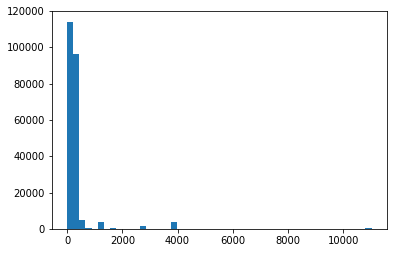

In [18]:
print(train['judgment_amount'].nunique())
print(train['judgment_amount'].min(), train['judgment_amount'].max())
plt.hist(train['judgment_amount'], 50);

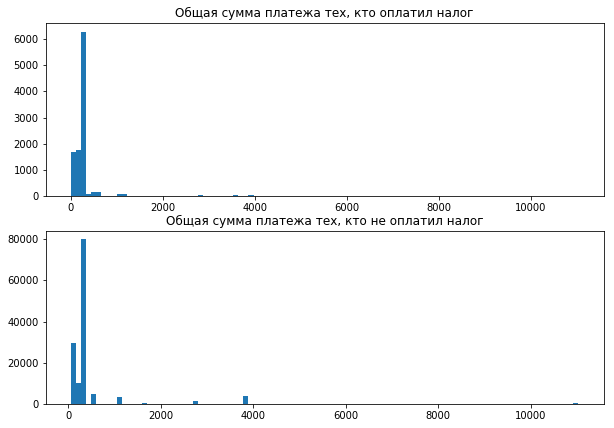

In [19]:
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.title('Общая сумма платежа тех, кто оплатил налог')
plt.hist(train_paid['judgment_amount'],100);
plt.subplot(2,1,2)
plt.title('Общая сумма платежа тех, кто не оплатил налог')
plt.hist(train_not_paid['judgment_amount'],100);

Гитограммы показывают, что общая сумма платежей у обеих групп имеет максимальное распределение в диапазоне от 0 до 500 платежных единиц. Графики очень даже похожи друг на друга, т.е. среди налогонеплательщиков нет налогов с очень большой суммой, которую невозможно покрыть, хотя на второй гистаграмме есть очень маленький процент налогоплательщиков с суммой > 10.000

In [20]:
# процент людей с налогом > 10 тыс
train_not_paid[train_not_paid['judgment_amount'] > 10000].shape[0] / train_not_paid.shape[0]

0.001447318357815892

In [21]:
train_not_paid[train_not_paid['judgment_amount'] > 10000]['violation_description'].value_counts().head()

Failure of owner to keep property, its sidewalks, or adjoining public property free from solid waste                                      185
Failure of owner to keep property, its sidewalks, or adjoining public property free from medical or hazardous waste                         4
Failure to remove, or cause to be removed, and properly dispose of solid waste before vacting priovate property or water                    2
Dumping,  or deposting solid waste of five (5) cubic feet or more from any motor vehicle upon any public or private property or street      1
Dumping, storing or depositing solid waste on any publicly-owned property, or private property or water, without a permit                   1
Name: violation_description, dtype: int64

Удивительно, но самая распространенная причина такой большой суммы налога - это неспособность владельца содержать имущество, тротуары или прилегающую общественную собственность без твердых отходов.

#### Explore additional information

In [22]:
# payment_amount – размер оплаты
# payment_date – дата оплаты
# payment_status – статус оплаты по состоянию на 01/02/2017
# balance_due – остаток штрафа
# collection_status – флаг для платежей в процессе сбора
# compliance_detail – краткое описание статуса целевой переменной
additional_train_columns = ['payment_amount', 'payment_date', 'payment_status', 'balance_due',
                            'collection_status', 'compliance_detail', 'compliance']
print(train['payment_date'].min(), train['payment_date'].max())
print(train['balance_due'].min(), train['balance_due'].max())
print(train['collection_status'].value_counts())
train[additional_train_columns].dropna().corr()['compliance'].dropna().sort_values()

2005-01-25 00:00:00 2017-01-25 00:00:00
-7750.0 11030.0
IN COLLECTION    32744
Name: collection_status, dtype: int64


balance_due      -0.074192
payment_amount    0.152199
compliance        1.000000
Name: compliance, dtype: float64

In [23]:
train_paid = train[train['compliance'] == 1]
train_not_paid = train[train['compliance'] == 0]
train_paid.shape, train_not_paid.shape

((10487, 34), (134041, 34))

In [24]:
# compliance_detail
train['compliance_detail'].value_counts()

non-compliant by no payment                        116236
not responsible by disposition                      79908
non-compliant by late payment more than 1 month     17805
compliant by late payment within 1 month             5665
compliant by on-time payment                         3555
compliant by early payment                            989
not responsible by pending judgment disposition       564
compliant by payment with no scheduled hearing        140
compliant by no fine                                   69
compliant by payment on unknown date                   69
Name: compliance_detail, dtype: int64

In [25]:
train_paid['compliance_detail'].value_counts()

compliant by late payment within 1 month          5665
compliant by on-time payment                      3555
compliant by early payment                         989
compliant by payment with no scheduled hearing     140
compliant by payment on unknown date                69
compliant by no fine                                69
Name: compliance_detail, dtype: int64

In [26]:
train_not_paid['compliance_detail'].value_counts().head()

non-compliant by no payment                        116236
non-compliant by late payment more than 1 month     17805
Name: compliance_detail, dtype: int64

Интересный флаг **'compliance_detail'**, который дает знать о характере оплаты человека, о том, как стабильно проводятся выплаты.
Этот флаг имеется у всех записей в датасет, и мог бы стать важным признаком определения платежеспособности.

In [27]:
# payment_status
train['payment_status'].value_counts()

NO PAYMENT APPLIED         186862
PAID IN FULL                29591
PARTIAL PAYMENT APPLIED      8547
Name: payment_status, dtype: int64

In [28]:
train_paid['payment_status'].value_counts()

PAID IN FULL          10420
NO PAYMENT APPLIED       67
Name: payment_status, dtype: int64

In [29]:
train_not_paid['payment_status'].value_counts()

NO PAYMENT APPLIED         107689
PAID IN FULL                17805
PARTIAL PAYMENT APPLIED      8547
Name: payment_status, dtype: int64

Признак **'paymnet_status'** также бы являлся одним из определяющих признаков платежеспособности

582
-7750.0 11030.0 25.0


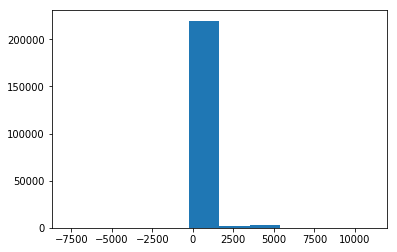

In [30]:
# balance_due
print(train['balance_due'].nunique())
print(train['balance_due'].min(), train['balance_due'].max(), train['balance_due'].median())
plt.hist(train['balance_due'], 10);

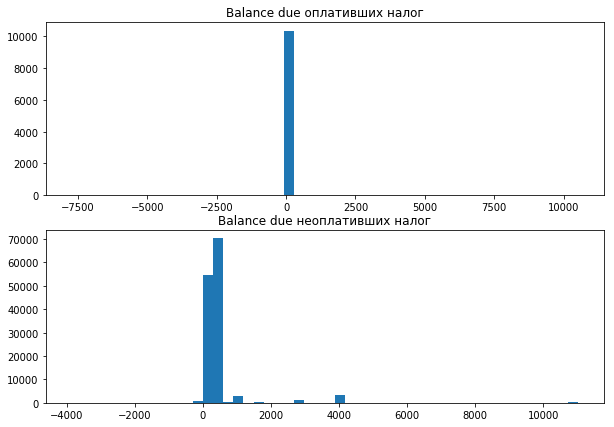

In [31]:
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.title('Balance due оплативших налог')
plt.hist(train_paid['balance_due'],50);
plt.subplot(2,1,2)
plt.title('Balance due неоплативших налог')
plt.hist(train_not_paid['balance_due'],50);

511
0.0 11075.0


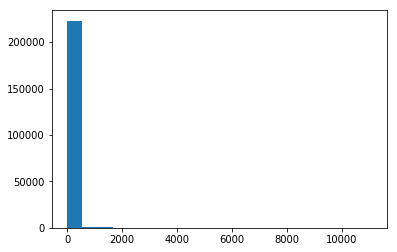

In [32]:
# payment_amount
print(train['payment_amount'].nunique())
print(train['payment_amount'].min(), train['payment_amount'].max())
plt.hist(train['payment_amount'], 20);

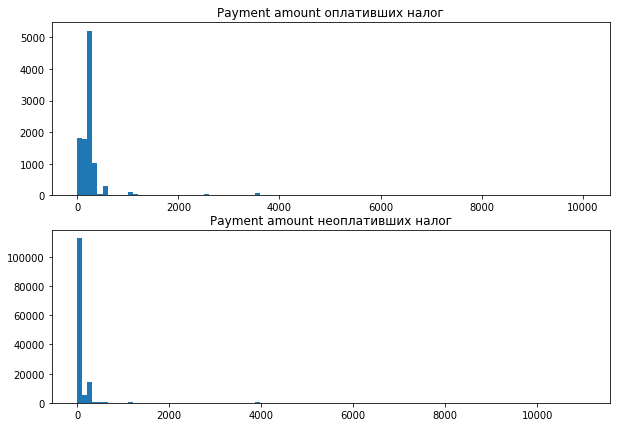

In [33]:
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.title('Payment amount оплативших налог')
plt.hist(train_paid['payment_amount'],100);
plt.subplot(2,1,2)
plt.title('Payment amount неоплативших налог')
plt.hist(train_not_paid['payment_amount'],100);

Теперь посмотрим разницу между общей суммой платежа и оплаченной суммой

In [34]:
data_columns = ['ticket_issued_date', 'compliance']
data = pd.DataFrame()
data['difference_amount'] = train['judgment_amount'] - train['payment_amount']
data[data_columns] = train[data_columns]
data_paid = data[data['compliance'] == 1]
data_not_paid = data[data['compliance'] == 0]

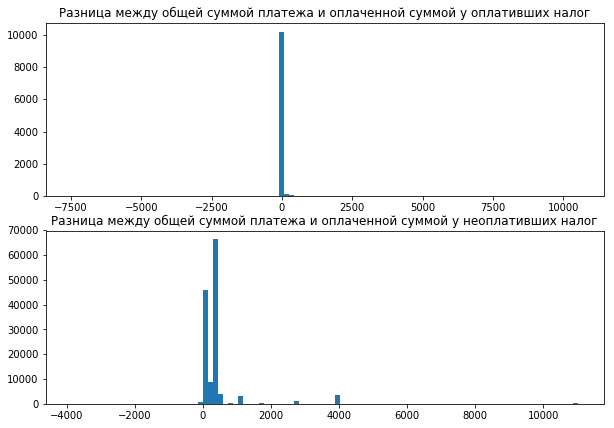

In [35]:
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.title('Разница между общей суммой платежа и оплаченной суммой у оплативших налог')
plt.hist(data_paid['difference_amount'],100);
plt.subplot(2,1,2)
plt.title('Разница между общей суммой платежа и оплаченной суммой у неоплативших налог')
plt.hist(data_not_paid['difference_amount'],100);

Что и следовало ожидать: учитывая графики общей суммы платежа и оплаченной суммой, у оплативших налог разница между этими двумя суммами стремится к нулю, в то время как у неоплативших налог, такая тенденция не проявляется

In [36]:
# payment_date
print(train['payment_date'].nunique())
print(train['payment_date'].min(), train['payment_date'].max())

2203
2005-01-25 00:00:00 2017-01-25 00:00:00


In [37]:
data_paid['duration_paymnet_days'] = (train_paid['payment_date'] - data_paid['ticket_issued_date']).apply(lambda x: x.days)
data_not_paid['duration_paymnet_days'] = (train_not_paid['payment_date'] - \
                                          data_not_paid['ticket_issued_date']).apply(lambda x: x.days)

In [38]:
# медианы длительности от выписки штрафа до её оплаты для двух категорий налогоплательщиков
data_paid['duration_paymnet_days'].median(), data_not_paid['duration_paymnet_days'].median()

(56.0, 181.0)

In [39]:
# collection_status
print('Unique values :    ' + str(train_paid['collection_status'].nunique()))
print(train_paid['collection_status'].value_counts())
print(train_not_paid['collection_status'].value_counts())
print(train_paid.shape, train_not_paid.shape)

Unique values :    1
IN COLLECTION    115
Name: collection_status, dtype: int64
IN COLLECTION    32629
Name: collection_status, dtype: int64
(10487, 34) (134041, 34)


Далеко неочевидный признак всего с одним уникальным значением, у которого большая часть значений неопределена

### Preprocess data

#### Missing values

In [40]:
def missing_values(file):
    sum_miss_val = file.isnull().sum()
    percent_miss_val = sum_miss_val * 100 / len(file)
    miss_val_table = pd.concat([sum_miss_val, percent_miss_val], axis = 1)
    miss_val_table = miss_val_table.rename(columns = {0 : 'Missing values', 
                                                      1 : '% of Total values'})
    miss_val_table = miss_val_table[miss_val_table.iloc[:,1] != 0].sort_values(
        '% of Total values', ascending=False).round(1)
    return miss_val_table

In [41]:
missing_values(train)

,Missing values,% of Total values
violation_zip_code,225000,100.0
grafitti_status,225000,100.0
non_us_str_code,224999,100.0
collection_status,192256,85.4
payment_date,186862,83.0
compliance,80472,35.8
hearing_date,10896,4.8
mailing_address_str_number,2895,1.3
violator_name,31,0.0
state,21,0.0


In [42]:
missing_values(test)

,Missing values,% of Total values
violation_zip_code,25305,100.0
grafitti_status,25304,100.0
non_us_str_code,25303,100.0
hearing_date,1595,6.3
mailing_address_str_number,707,2.8
state,72,0.3
violator_name,3,0.0


In [43]:
# признаки, где нет ни одногой записи со значением
only_missing_columns = ['violation_zip_code', 'grafitti_status', 'non_us_str_code']

# признаки, которые есть только в train.csv, но нет в test.csv 
additional_train_columns = ['payment_amount', 'payment_date', 'payment_status', 'balance_due', 'collection_status',
                            'compliance_detail']

train.drop(columns= only_missing_columns,axis = 1, inplace = True)
train.dropna(subset = ['compliance'], inplace = True)
train.drop(columns= additional_train_columns,axis = 1, inplace = True)

test.drop(columns= only_missing_columns,axis = 1, inplace = True)

In [44]:
missing_values(train)

,Missing values,% of Total values
mailing_address_str_number,2108,1.5
hearing_date,190,0.1
violator_name,24,0.0
state,19,0.0
mailing_address_str_name,3,0.0
zip_code,1,0.0


In [45]:
missing_values(test)

,Missing values,% of Total values
hearing_date,1595,6.3
mailing_address_str_number,707,2.8
state,72,0.3
violator_name,3,0.0


In [46]:
# Размерность датасетов после удаления записей с 'compliance' = NaN
train.shape, test.shape

((144528, 25), (25305, 24))

In [47]:
# Теперь найдем самый популярное значение в каждом признаке, чтобы заменить им пропущенные значения
columns_miss_values = ['hearing_date', 'mailing_address_str_number', 'state', 'violator_name']
columns_miss_values_left = ['mailing_address_str_name', 'zip_code']

for col in columns_miss_values:
    print(train[col].value_counts().head(1))
    print(test[col].value_counts().head(1))

for col in columns_miss_values_left:
    print(train[col].value_counts().head(1))

2005-12-20 09:00:00    590
Name: hearing_date, dtype: int64
2011-03-07 13:30:00    99
Name: hearing_date, dtype: int64
213.0    1481
Name: mailing_address_str_number, dtype: int64
1.0    214
Name: mailing_address_str_number, dtype: int64
MI    130681
Name: state, dtype: int64
MI    22186
Name: state, dtype: int64
INVESTMENT, ACORN    618
Name: violator_name, dtype: int64
FARWELL, WILLIAM B    100
Name: violator_name, dtype: int64
PO BOX    5614
Name: mailing_address_str_name, dtype: int64
48221    4030
Name: zip_code, dtype: int64


In [48]:
train['hearing_date'].fillna('2005-12-20 09:00:00', inplace = True)
train['mailing_address_str_number'].fillna('213.0', inplace = True)
train['state'].fillna('MI', inplace = True)
train['violator_name'].fillna('INVESTMENT, ACORN', inplace = True)

test['hearing_date'].fillna('2011-03-07 13:30:00', inplace = True)
test['mailing_address_str_number'].fillna('1.0', inplace = True)
test['state'].fillna('MI', inplace = True)
test['violator_name'].fillna('FARWELL, WILLIAM B', inplace = True)

In [49]:
train['mailing_address_str_name'].fillna('PO BOX', inplace = True)
train['zip_code'].fillna('48221', inplace = True)

In [50]:
missing_values(train)

,Missing values,% of Total values


In [51]:
missing_values(test)

,Missing values,% of Total values


In [52]:
# Важно, что размерность после преобразования пропущенных значений не была изменена
train.shape, test.shape

((144528, 25), (25305, 24))

In [53]:
# Признак стоимости удаления граффити со стены полностью содержит значению из нулей, что не несет никакой информации
# Поэтому и его удалим из train.csv и test.csv
train['clean_up_cost'].value_counts()

0.0    144528
Name: clean_up_cost, dtype: int64

In [54]:
# Аналогично и с государственной составляющий налога
train['state_fee'].value_counts()

10.0    144528
Name: state_fee, dtype: int64

In [55]:
const_columns_drop = ['clean_up_cost', 'state_fee']
train.drop(columns= const_columns_drop,axis = 1, inplace = True)
test.drop(columns= const_columns_drop,axis = 1, inplace = True)

In [56]:
train.shape, test.shape

((144528, 23), (25305, 22))

In [57]:
train.columns

Index(['ticket_id', 'agency_name', 'inspector_name', 'violator_name',
       'violation_street_number', 'violation_street_name',
       'mailing_address_str_number', 'mailing_address_str_name', 'city',
       'state', 'zip_code', 'country', 'ticket_issued_date', 'hearing_date',
       'violation_code', 'violation_description', 'disposition', 'fine_amount',
       'admin_fee', 'late_fee', 'discount_amount', 'judgment_amount',
       'compliance'],
      dtype='object')

In [58]:
y_train = train['compliance']

#### Numerical features scaling

In [59]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144528 entries, 0 to 224999
Data columns (total 23 columns):
ticket_id                     144528 non-null int64
agency_name                   144528 non-null object
inspector_name                144528 non-null object
violator_name                 144528 non-null object
violation_street_number       144528 non-null float64
violation_street_name         144528 non-null object
mailing_address_str_number    144528 non-null object
mailing_address_str_name      144528 non-null object
city                          144528 non-null object
state                         144528 non-null object
zip_code                      144528 non-null object
country                       144528 non-null object
ticket_issued_date            144528 non-null datetime64[ns]
hearing_date                  144528 non-null object
violation_code                144528 non-null object
violation_description         144528 non-null object
disposition                   144

In [60]:
train['mailing_address_str_number'] = train['mailing_address_str_number'].astype('float64');
test['mailing_address_str_number'] = test['mailing_address_str_number'].astype('float64');
train['hearing_date'] = train['hearing_date'].astype('datetime64');
test['hearing_date'] = test['hearing_date'].astype('datetime64');

In [61]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144528 entries, 0 to 224999
Data columns (total 23 columns):
ticket_id                     144528 non-null int64
agency_name                   144528 non-null object
inspector_name                144528 non-null object
violator_name                 144528 non-null object
violation_street_number       144528 non-null float64
violation_street_name         144528 non-null object
mailing_address_str_number    144528 non-null float64
mailing_address_str_name      144528 non-null object
city                          144528 non-null object
state                         144528 non-null object
zip_code                      144528 non-null object
country                       144528 non-null object
ticket_issued_date            144528 non-null datetime64[ns]
hearing_date                  144528 non-null datetime64[ns]
violation_code                144528 non-null object
violation_description         144528 non-null object
disposition             

In [62]:
# Создадим наборы данных, содержащих только численные значения для удобства исследования и предобработки
train_num = train.select_dtypes('float64')
test_num = test.select_dtypes('float64')

num_df = pd.concat([train_num.drop('compliance', axis = 1), test_num])
index_split_num = train_num.shape[0]

In [63]:
train_num.shape, test_num.shape, num_df.shape

((144528, 8), (25305, 7), (169833, 7))

In [64]:
num_df.describe()

,violation_street_number,mailing_address_str_number,fine_amount,admin_fee,late_fee,discount_amount,judgment_amount
count,1.698330e+05,1.698330e+05,169833.000000,169833.00000,169833.000000,169833.000000,169833.000000
mean,1.069378e+04,8.912033e+03,359.067896,18.82779,31.679349,0.184475,395.997667
std,3.521791e+04,3.563232e+04,671.921235,4.69790,66.153319,4.162982,727.211467
min,0.000000e+00,1.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000
25%,4.858000e+03,4.710000e+02,200.000000,20.00000,5.000000,0.000000,140.000000
50%,1.032000e+04,2.291000e+03,250.000000,20.00000,25.000000,0.000000,305.000000
75%,1.579100e+04,1.263100e+04,250.000000,20.00000,25.000000,0.000000,305.000000
max,1.415411e+07,5.111345e+06,10000.000000,20.00000,1000.000000,350.000000,11030.000000


In [65]:
num_df.nunique()

violation_street_number       18246
mailing_address_str_number    14358
fine_amount                      41
admin_fee                         2
late_fee                         37
discount_amount                  13
judgment_amount                  57
dtype: int64

In [66]:
num_df['violation_street_number'].value_counts().head()

1509.0     187
600.0      159
1401.0     116
0.0        108
19300.0    103
Name: violation_street_number, dtype: int64

In [67]:
maxabs = MaxAbsScaler()
minmax = MinMaxScaler()
# onehot = OneHotEncoder()
# scaler = StandardScaler(copy = True)
# num_df_fee_amount = num_df.drop(columns= ['violation_street_number', 'mailing_address_str_number'], axis = 1)


num_df_scal = maxabs.fit_transform(num_df)

print(pd.DataFrame(num_df_scal).shape)
pd.DataFrame(num_df_scal).describe()

(169833, 7)


,0,1,2,3,4,5,6
count,169833.000000,1.698330e+05,169833.000000,169833.000000,169833.000000,169833.000000,169833.000000
mean,0.000756,1.743579e-03,0.035907,0.941389,0.031679,0.000527,0.035902
std,0.002488,6.971223e-03,0.067192,0.234895,0.066153,0.011894,0.065930
min,0.000000,1.956432e-07,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000343,9.214796e-05,0.020000,1.000000,0.005000,0.000000,0.012693
50%,0.000729,4.482186e-04,0.025000,1.000000,0.025000,0.000000,0.027652
75%,0.001116,2.471170e-03,0.025000,1.000000,0.025000,0.000000,0.027652
max,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000


In [68]:
X_train_num = pd.DataFrame(num_df_scal).iloc[:index_split_num, :]
X_test_num = pd.DataFrame(num_df_scal).iloc[index_split_num:, :]

X_train_num.columns = ['violation_street_number', 'mailing_address_str_number', 'fine_amount', 'admin_fee', 'late_fee', 
                       'discount_amount', 'judgment_amount']
X_test_num.columns = ['violation_street_number', 'mailing_address_str_number', 'fine_amount', 'admin_fee', 'late_fee', 
                       'discount_amount', 'judgment_amount']

X_train_num.shape, X_test_num.shape

((144528, 7), (25305, 7))

#### Date features scaling

In [69]:
# Создадим наборы данных, содержащих только значения с типом datetime для удобства исследования и предобработки
train_date = train.select_dtypes('datetime64')
test_date = test.select_dtypes('datetime64')

date_df = pd.concat([train_date, test_date])
index_split_date = train_date.shape[0]

In [70]:
# создадим новые признаки
date_df['duration_to_hearing_days'] = (date_df['hearing_date'] - date_df['ticket_issued_date']).apply(lambda x: x.days)
date_df['duration_to_hearing_months'] = date_df['duration_to_hearing_days'] // 30
date_df['duration_to_hearing_years'] = date_df['duration_to_hearing_days'] // 365

In [71]:
date_df['ticket_issues_date_year'] = date_df['ticket_issued_date'].apply(lambda x: x.year)
date_df['ticket_issues_date_month'] = date_df['ticket_issued_date'].apply(lambda x: x.month)
date_df['ticket_issues_date_day'] = date_df['ticket_issued_date'].apply(lambda x: x.day)
date_df['ticket_issues_date_hour'] = date_df['ticket_issued_date'].apply(lambda x: x.hour)

date_df['hearing_date_year'] = date_df['hearing_date'].apply(lambda x: x.year)
date_df['hearing_date_month'] = date_df['hearing_date'].apply(lambda x: x.month)
date_df['hearing_date_day'] = date_df['hearing_date'].apply(lambda x: x.day)
date_df['hearing_date_hour'] = date_df['hearing_date'].apply(lambda x: x.hour)

In [72]:
date_df.head()

,ticket_issued_date,hearing_date,duration_to_hearing_days,duration_to_hearing_months,duration_to_hearing_years,ticket_issues_date_year,ticket_issues_date_month,ticket_issues_date_day,ticket_issues_date_hour,hearing_date_year,hearing_date_month,hearing_date_day,hearing_date_hour
0,2004-03-16 11:40:00,2005-03-21 10:30:00,369,12,1,2004,3,16,11,2005,3,21,10
1,2004-04-23 12:30:00,2005-05-06 13:30:00,378,12,1,2004,4,23,12,2005,5,6,13
5,2004-05-01 11:50:00,2005-03-21 10:30:00,323,10,0,2004,5,1,11,2005,3,21,10
6,2004-06-14 14:15:00,2005-02-22 15:00:00,253,8,0,2004,6,14,14,2005,2,22,15
7,2004-06-16 12:30:00,2005-02-22 15:00:00,251,8,0,2004,6,16,12,2005,2,22,15


In [73]:
date_df_columns = ['duration_to_hearing_days', 'duration_to_hearing_months', 'duration_to_hearing_years',
                   'ticket_issues_date_year', 'ticket_issues_date_month', 'ticket_issues_date_day',
                   'ticket_issues_date_hour', 'hearing_date_year','hearing_date_month',
                   'hearing_date_day', 'hearing_date_hour']

date_df_scaler = minmax.fit_transform(date_df[date_df_columns])

date_df_scaler = pd.DataFrame(date_df_scaler)
date_df_scaler.columns = date_df_columns
date_df_scaler.describe()

,duration_to_hearing_days,duration_to_hearing_months,duration_to_hearing_years,ticket_issues_date_year,ticket_issues_date_month,ticket_issues_date_day,ticket_issues_date_hour,hearing_date_year,hearing_date_month,hearing_date_day,hearing_date_hour
count,169833.000000,169833.000000,169833.000000,169833.000000,169833.000000,169833.000000,169833.000000,169833.000000,169833.000000,169833.000000,169833.000000
mean,0.184737,0.185853,0.192141,0.857009,0.488798,0.487083,0.460870,0.262709,0.507184,0.478266,0.251486
std,0.007415,0.007516,0.005555,0.082706,0.301088,0.288703,0.088672,0.175909,0.306844,0.289652,0.253914
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.180527,0.183230,0.192308,0.782609,0.181818,0.233333,0.391304,0.090909,0.272727,0.200000,0.000000
50%,0.182912,0.183230,0.192308,0.869565,0.454545,0.466667,0.434783,0.272727,0.454545,0.466667,0.111111
75%,0.187681,0.189441,0.192308,0.913043,0.727273,0.733333,0.521739,0.363636,0.818182,0.700000,0.444444
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [74]:
X_train_date = pd.DataFrame(date_df[date_df_columns]).iloc[:index_split_date, :]
X_test_date = pd.DataFrame(date_df[date_df_columns]).iloc[index_split_date:, :]

X_train_date.columns = date_df_columns
X_test_date.columns = date_df_columns

X_train_date.shape, X_test_date.shape

((144528, 11), (25305, 11))

In [75]:
X_train = hstack([X_train_num, X_train_date])
X_test = hstack([X_test_num, X_test_date])
X_train, X_test

(<144528x18 sparse matrix of type '<class 'numpy.float64'>'
 	with 2267622 stored elements in COOrdinate format>,
 <25305x18 sparse matrix of type '<class 'numpy.float64'>'
 	with 364908 stored elements in COOrdinate format>)

#### Text features scaling

In [76]:
# Создадим наборы данных, содержащих только значения с типом object для удобства исследования и предобработки
train_text = train.select_dtypes('object')
test_text = test.select_dtypes('object')

text_df = pd.concat([train_text, test_text])
index_split_text = train_text.shape[0]

In [77]:
text_df.head(3)

,agency_name,inspector_name,violator_name,violation_street_name,mailing_address_str_name,city,state,zip_code,country,violation_code,violation_description,disposition
0,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",TYLER,S. WICKER,CHICAGO,IL,60606,USA,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default
1,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",CENTRAL,Martin Luther King,Detroit,MI,48208,USA,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Determination
5,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","KASIMU, UKWELI",NORTHFIELD,E. 17TH,LOG BEACH,CA,908041512,USA,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default


In [78]:
text_df['violator_name'].value_counts().head()

INVESTMENT, ACORN        649
INVESTMENT CO., ACORN    343
BANK, WELLS FARGO        261
MILLER, JOHN             179
STEHLIK, JERRY           158
Name: violator_name, dtype: int64

In [79]:
text_df.nunique()

agency_name                     5
inspector_name                161
violator_name               89368
violation_street_name        1731
mailing_address_str_name    29892
city                         4306
state                          59
zip_code                     4711
country                         5
violation_code                206
violation_description         227
disposition                     9
dtype: int64

In [80]:
# Приведем все символы к нижнему регистру
text_df_zip = text_df['zip_code']
text_df.drop(columns='zip_code', axis=1,inplace=True)
for column in text_df.columns:
    text_df[column] = text_df[column].apply(lambda x: x.lower())
text_df['zip_code'] = text_df_zip
text_df.head(3)

,agency_name,inspector_name,violator_name,violation_street_name,mailing_address_str_name,city,state,country,violation_code,violation_description,disposition,zip_code
0,"buildings, safety engineering & env department","sims, martinzie","investment inc., midwest mortgage",tyler,s. wicker,chicago,il,usa,9-1-36(a),failure of owner to obtain certificate of comp...,responsible by default,60606
1,"buildings, safety engineering & env department","williams, darrin","michigan, covenant house",central,martin luther king,detroit,mi,usa,61-63.0600,failed to secure permit for lawful use of buil...,responsible by determination,48208
5,"buildings, safety engineering & env department","sims, martinzie","kasimu, ukweli",northfield,e. 17th,log beach,ca,usa,9-1-36(a),failure of owner to obtain certificate of comp...,responsible by default,908041512


In [81]:
text_df.nunique()

agency_name                     5
inspector_name                160
violator_name               84897
violation_street_name        1731
mailing_address_str_name    26529
city                         3626
state                          59
country                         5
violation_code                206
violation_description         226
disposition                     9
zip_code                     4711
dtype: int64

In [82]:
#ordinal = OrdinalEncoder()

#text_df_ordinal_columns = ['agency_name', 'state', 'country', 'disposition']

#text_df_ordinal = ordinal.fit_transform(text_df[text_df_ordinal_columns])
#text_df_ordinal_scal = scaler.fit_transform(text_df_ordinal)

#text_df_ordinal_scal = pd.DataFrame(text_df_ordinal_scal)
#text_df_ordinal_scal.columns = text_df_ordinal_columns
#text_df_ordinal_scal.describe()

In [83]:
X_train_text = pd.DataFrame(text_df).iloc[:index_split_text, :]
X_test_text = pd.DataFrame(text_df).iloc[index_split_text:, :]

X_train_text.columns = text_df.columns
X_test_text.columns = text_df.columns

X_train_text.shape, X_test_text.shape

((144528, 12), (25305, 12))

In [84]:
def vectorizer(train_full, X_train, X_test):
    word_vectorizer = TfidfVectorizer(
        sublinear_tf=True,
        strip_accents='unicode',
        analyzer='word',
        token_pattern=r'\w{1,}',
        # delete english stopwords
        stop_words=stopwords.words('english'),
        ngram_range=(1, 2),
        max_features=50000)
    word_vectorizer.fit(train_full)
    train_word_features = word_vectorizer.transform(X_train)
    test_word_features = word_vectorizer.transform(X_test)
    return train_word_features, test_word_features

In [85]:
text_df.drop(columns=['zip_code', 'violator_name'], axis = 1, inplace = True)

In [86]:
text_df.columns

Index(['agency_name', 'inspector_name', 'violation_street_name',
       'mailing_address_str_name', 'city', 'state', 'country',
       'violation_code', 'violation_description', 'disposition'],
      dtype='object')

In [87]:
%%time
for col in text_df.columns:
    train_word_features, test_word_features = vectorizer(text_df[col], X_train_text[col], X_test_text[col])
    X_train = hstack([X_train, train_word_features])
    X_test = hstack([X_test, test_word_features])
    print(X_train.shape, X_test.shape)

(144528, 42) (25305, 42)
(144528, 502) (25305, 502)
(144528, 2474) (25305, 2474)
(144528, 29911) (25305, 29911)
(144528, 34280) (25305, 34280)
(144528, 34334) (25305, 34334)
(144528, 34339) (25305, 34339)
(144528, 34732) (25305, 34732)
(144528, 36216) (25305, 36216)
(144528, 36241) (25305, 36241)
Wall time: 2min 14s


In [88]:
# 25194 mailing_address_str_name
# 1476 violation_description
# 391 violation_code
# 50000 violator_name
# 460 inspector_name
# 52 state
# 24 agency_name
# 1962 violation_street_name
# 3 country
# 21 disposition
# zip_code (нужно удалить символы и вставить в numerical)

### Building predictive model

In [89]:
def get_auc_log_regr_valid(X, y, C=0.17, seed=17):
    # Split the data into the training and validation sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
    log_regr = LogisticRegression(C=C, random_state=seed, solver='liblinear').fit(X_train, y_train)
    #Predict
    y_pred = log_regr.predict_proba(X_test)[:, 1]
    # ROC_AUC. Probality.
    score = roc_auc_score(y_test, y_pred)
    
    return score

In [90]:
# 0.768
# 0.798 TFIDVectorizer()

In [91]:
%%time
# получим ROC-AUC значение, используя train_test_split со значением test_split=0.25 по умолчанию
print(get_auc_log_regr_valid(X_train, y_train))

0.7981616410371767
Wall time: 21.6 s


In [92]:
log_regr = LogisticRegression(C=0.17, random_state=17, solver='liblinear').fit(X_train, y_train)

In [93]:
%%time
cv_score = cross_val_score(log_regr, X=X_train, y=pd.factorize(y_train)[0],
                                   scoring='roc_auc', cv=10)
print(np.mean(cv_score))

0.7585871705162642
Wall time: 2min 47s


In [94]:
log_regr.fit(X_train, y_train)
y_test_pred = log_regr.predict_proba(X_test)[:, 1]

In [95]:
y_test_pred.shape, X_test.shape

((25305,), (25305, 36241))

In [96]:
sub = pd.DataFrame({'ticket_id': test['ticket_id'],
                    'score': y_test_pred})
sub.to_csv('submission_tfid_param.csv', index = False)

In [97]:
pd.read_csv('submission_tfid_param.csv').head()

,ticket_id,score
0,259669,0.040829
1,259733,0.025210
2,258776,0.048551
3,258777,0.041472
4,259663,0.273092


In [98]:
sub.shape, test.shape

((25305, 2), (25305, 22))

In [99]:
pd.DataFrame(y_test_pred).head(15)

,0
0,0.040829
1,0.025210
2,0.048551
3,0.041472
4,0.273092
5,0.183742
6,0.037382
7,0.023137
8,0.016868
9,0.027839
